In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import concurrent.futures
import timeit
from typing import Callable, List, Optional, Tuple
from functools import partial
import copy
from itertools import groupby
import sys, os
from scipy.optimize import minimize
from scipy.spatial.distance import (
    cosine
)

from data_loader import load_grid_search_data

# plt.rcParams['figure.figsize'] = (15.0, 8.0)

In [2]:

def _vis_landscapes(
        landscapes, # list of np.ndarray
        labels, # list of labels of correlated landscapes
        full_range, # dict, 
        true_optima,
        title,
        save_path, # figure save path
        params_paths, # list of list of parameters correlated to landscapes
        recon_params_path_dict=None,
        origin_params_path_dict=None,
        converged_soln_markers=None,
    ):

    assert len(landscapes) == len(labels)
    assert len(landscapes) == len(params_paths)

    # plt.figure
    plt.rc('font', size=28)
    if len(landscapes) == 2:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
    elif len(landscapes) == 3:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
    elif len(landscapes) == 4:
        fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(30, 30))
    else:
        assert False

    fig.suptitle(title)
    axs = axs.reshape(-1)

    # TODO Check ij and xy
    X, Y = np.meshgrid(full_range['beta'], full_range['gamma'])

    # c = ax.pcolormesh(X, Y, Z, cmap='viridis', vmin=Z.min(), vmax=Z.max())
    for idx, landscape in enumerate(landscapes):
        im = axs[idx].pcolormesh(X, Y, landscape) #, cmap='viridis', vmin=origin.min(), vmax=origin.max())
        axs[idx].set_title(labels[idx])
        axs[idx].set_xlabel('beta')
        axs[idx].set_ylabel('gamma')
        if isinstance(true_optima, list) or isinstance(true_optima, np.ndarray):
            axs[idx].plot(true_optima[1], true_optima[0], marker="o", color='red', markersize=7, label="true optima")

        params = params_paths[idx]
        if isinstance(params, list) or isinstance(params, np.ndarray):
            xs = [] # beta
            ys = [] # gamma
            for param in params:
                xs.append(param[1])
                ys.append(param[0])

            axs[idx].plot(xs, ys, linewidth=3, color='purple', label="optimization path")
            axs[idx].plot(xs[0], ys[0], marker="o", color='white', markersize=9, label="initial point")

            if isinstance(converged_soln_markers, list):
                marker = converged_soln_markers[idx]
                if marker == '*':
                    markersize = 15
                elif marker == 'D':
                    markersize = 10
                
            else:
                marker = '*'
                markersize = 15

            axs[idx].plot(xs[-1], ys[-1], marker=marker,
                    color='red', markersize=markersize, label="converged solution")

            axs[idx].legend()

    fig.colorbar(im, ax=[axs[i] for i in range(len(landscapes))])
    # plt.legend()
    fig.savefig(save_path, bbox_inches='tight')
    plt.show()
    plt.close('all')

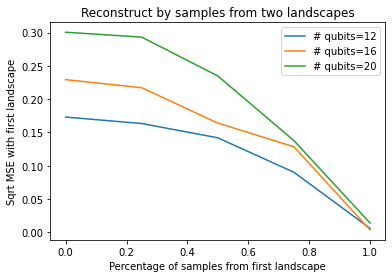

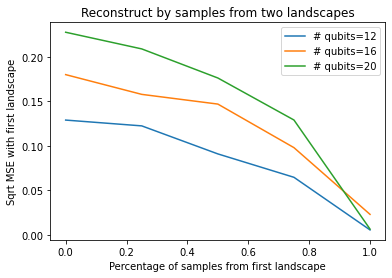

In [4]:
def cs_by_distributed_landscapes(config1: int, config2: int):
    if config1 == 1 and config2 == 2:
        data_paths = [
            "figs/recon_distributed_landscape/2022-11-05_12:51:53_OK/distributed_LS_errors-n=12-p=1-noise1=depolar-0.001-0.005-noise2=depolar-0.001-0.02.npz",
            "figs/recon_distributed_landscape/2022-11-05_12:53:56_OK/distributed_LS_errors-n=16-p=1-noise1=depolar-0.001-0.005-noise2=depolar-0.001-0.02.npz",
            "figs/recon_distributed_landscape/2022-11-05_12:55:51_OK/distributed_LS_errors-n=20-p=1-noise1=depolar-0.001-0.005-noise2=depolar-0.001-0.02.npz"
        ]
    elif config1 == 2 and config2 == 3:
        data_paths = [
            "figs/recon_distributed_landscape/2022-11-10_13:47:08_OK/distributed_LS_errors-n=12-p=1-noise1=depolar-0.003-0.007-noise2=depolar-0.001-0.02.npz",
            "figs/recon_distributed_landscape/2022-11-10_13:51:25_OK/distributed_LS_errors-n=16-p=1-noise1=depolar-0.003-0.007-noise2=depolar-0.001-0.02.npz",
            "figs/recon_distributed_landscape/2022-11-10_13:56:38_OK/distributed_LS_errors-n=20-p=1-noise1=depolar-0.003-0.007-noise2=depolar-0.001-0.02.npz"
        ]
    
    datas = []
    for data_dir in data_paths:
        datas.append(np.load(data_dir, allow_pickle=True))

    nqs = [12, 16, 20]

    fig = plt.figure(figsize=[6, 4])
    ax = plt.axes()
    # for nq in nqs:
    for nq, data in zip(nqs, datas):
        errors1 = data['errors1']
        ratios = data['ratios']
        ax.plot(ratios, errors1, label=f"# qubits={nq}")

    # ax.plot(sf_range[start:], es_noisy, label=f"noisy, {nq_range[i]} qubits, {inst_range[j]}-th inst")
    ax.set_xlabel("Percentage of samples from first landscape")
    ax.set_ylabel("Sqrt MSE with first landscape")
    ax.set_title("Reconstruct by samples from two landscapes")
    plt.legend()
    fig.savefig("paper_figs/recon_error_by_distributed_LS.svg", bbox_inches='tight')
    plt.show()

    return
cs_by_distributed_landscapes(1, 2) # noise-1 and noise-2
cs_by_distributed_landscapes(2, 3) # noise-2 and noise-3

read data from  figs/grid_search/maxcut/sv-ideal-p=2/sv-ideal-n=16-p=2-seed=0-12-15.npz
{'bodies': [<matplotlib.collections.PolyCollection object at 0x15f30b580>], 'cmaxes': <matplotlib.collections.LineCollection object at 0x15f30b520>, 'cmins': <matplotlib.collections.LineCollection object at 0x15f30bc10>, 'cbars': <matplotlib.collections.LineCollection object at 0x15f30bfd0>, 'cquantiles': <matplotlib.collections.LineCollection object at 0x15f31e3d0>}

Pearson : r=+0.03265	 p=0.78394
Spearman: r=-0.09310	 p=0.43338


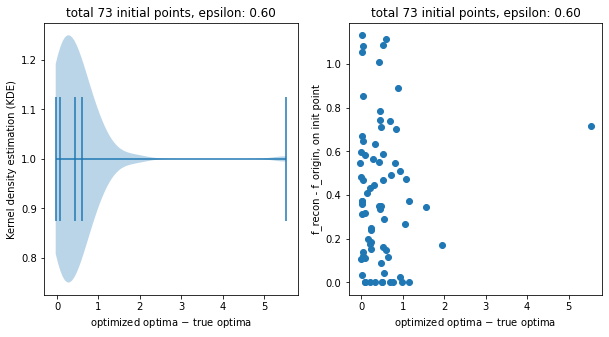

In [11]:

def vis_find_init_pts_by_recon(n_qubits: int, eps: float, noise: str):
    """n=20
    """
    method = 'sv'
    problem = 'maxcut'
    cs_seed = n_qubits
    p = 2

    sf = 0.05
    seed = 0
    if p == 2:
        bs = 12
        gs = 15
    elif p == 1:
        bs = 50
        gs = 100
    else:
        raise ValueError("Invalid depth of QAOA")

    data, data_fname, _ = load_grid_search_data(
        n_qubits=n_qubits, p=p, problem=problem, method=method,
        noise=noise, beta_step=bs, gamma_step=gs, seed=seed
    )
    origin = data['data']

    recon_path = f"figs/gen_p1_landscape/sv-ideal/2D_CS_recon_p2/sf{sf:.3f}_bs{bs}_gs{gs}_nQ{n_qubits}_seed{seed}_csSeed{cs_seed}.npz"
    recon = np.load(f"{recon_path}")['recon']

    # ====================== vis ======================
    # eps = 0.6
    if noise == 'ideal':
        init_data = np.load(
            "figs/find_init_pts_by_recon/2022-11-05_22:03:07_OK/recon-eps=0.600-csSeed=16-sv-ideal-n=16-p=2-seed=0-12-15.npz",
            allow_pickle=True) # eps = 0.3
    elif noise == 'depolar-0.001-0.02':
        return
    
    ids = init_data['ids']
    energies = init_data['min_energies']
    min_recon = init_data['min_recon']
    initial_points = init_data['initial_points']
    recon_init_pt_vals = init_data['recon_init_pt_vals']
    # offset = init_data['offset']
    # C_opt = init_data['C_opt']
    C_opt = -17.991035
    offset = -12
    # eps = init_data['eps']

    # print(ids)
    # print(energies)
    energies = np.array(energies, dtype=float)
    energies += offset
    # print(energies)

    # recon. error on the initial points
    recon_errors = []
    ids_needed = []
    for i in range(len(ids)): # idx: tuples
        # print(recon[idx[0], idx[1], idx[2], idx[3]])
        # print(recon[tuple(idx)])
        # print(idx, recon[idx[0], idx[1], idx[2], idx[3]])
        # continue

        init_recon = recon[tuple(ids[i])]
        init_origin = origin[tuple(ids[i])]
        
        if np.abs(min_recon - init_recon) >= eps:
            continue

        error = init_recon - init_origin
        # error = np.abs(init_recon - init_origin)
        error = np.abs(error)
        # print(init_origin, init_recon, error)
        recon_errors.append(error)
        ids_needed.append(i)

    ids_needed = np.array(ids_needed)
    # print(ids_needed)
    energies = energies[ids_needed]

    # ==================== vis =====================
    import matplotlib.patches as mpatches
    diff = C_opt - energies
    diff = energies - C_opt
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axs.reshape(-1)
    # plt.hist(diff, bins=50)
    # https://blog.csdn.net/mighty13/article/details/117405722
    rst = axs[0].violinplot(diff, quantiles=[0.25, 0.5, 0.75], vert=False)

    # color = rst['bodies'][0].get_facecolor().flatten()
    # patch = mpatches.Patch(color=color, label="")
    axs[0].set_xlabel("optimized optima $-$ true optima")
    # axs.set_ylabel("# initial points")
    axs[0].set_ylabel("Kernel density estimation (KDE)")
    # plt.legend()
    axs[0].set_title(f"total {len(ids_needed)} initial points, epsilon: {eps:.2f}")
    print(rst)
    print(rst['cquantiles'])

    # ============ correlation value ==========
    from scipy.stats import pearsonr, spearmanr
    r_p, p_p = pearsonr(diff, recon_errors)
    r_s, p_s = spearmanr(diff, recon_errors)
    print("")
    
    print(f"Pearson : r={r_p:+.5f}\t p={p_p:.5f}\n"
          f"Spearman: r={r_s:+.5f}\t p={p_s:.5f}")
    
    axs[1].scatter(diff, recon_errors)

    # color = rst['bodies'][0].get_facecolor().flatten()
    # patch = mpatches.Patch(color=color, label="")
    axs[1].set_xlabel("optimized optima $-$ true optima")
    # axs.set_ylabel("# initial points")
    axs[1].set_ylabel("f_recon - f_origin, on init point")
    # plt.legend()
    axs[1].set_title(f"total {len(ids_needed)} initial points, epsilon: {eps:.2f}")
    
    # plt.title(f"# qubits={n_qubits}, p={p}")

    # quantiles


vis_find_init_pts_by_recon(n_qubits=16, eps=0.6, noise="ideal")
# vis_find_init_pts_by_recon(n_qubits=16, eps=0.6, noise="depolar-0.001-0.02")
